# Market Impact and Order Book Events Analysis

This notebook reproduces some of the results from the paper:

Z. Eisler, J.-P. Bouchaud, and J. Kockelkoren. "The price impact of order book events: market orders, limit orders and cancellations". In: Quantitative Finance 12.9 (2012), pp. 1395–1419.

We'll analyze the price impact of different order book events and implement the following analyses:

1. Sign and side autocorrelation functions
2. Empirical response functions for the 6 types of events
3. Signed event-event correlations
4. Plotting with signed log-scale
5. Theoretical responses in the constant impact model compared to empirical ones

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import os
import glob
import gzip
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Data Loading and Preprocessing

First, we'll load and preprocess the financial data for analysis. We need to identify and categorize the different types of order book events.

In [2]:
def load_data(file_path):
    """Load and preprocess data from gzipped CSV file."""
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f)
    
    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
    
    # Extract mid-price
    df['mid_price'] = (df['bp0'] + df['ap0']) / 2
    
    # Calculate log mid-price
    df['log_mid_price'] = np.log(df['mid_price'])
    
    return df

# Get all data files
bnpp_files = sorted(glob.glob('Data/BNPP/BNPP_*.csv.gz'))
sg_files = sorted(glob.glob('Data/SG/SG_*.csv.gz'))

print("BNPP files:", [os.path.basename(f) for f in bnpp_files])
print("SG files:", [os.path.basename(f) for f in sg_files])

# Load one day of data for analysis
bnpp_data = load_data(bnpp_files[0])

print("\nBNPP data shape:", bnpp_data.shape)
print("\nBNPP data sample:")
display(bnpp_data.head())

BNPP files: ['BNPP_20170117.csv.gz', 'BNPP_20170118.csv.gz', 'BNPP_20170119.csv.gz', 'BNPP_20170120.csv.gz', 'BNPP_20170123.csv.gz', 'BNPP_20170124.csv.gz', 'BNPP_20170125.csv.gz', 'BNPP_20170126.csv.gz', 'BNPP_20170127.csv.gz', 'BNPP_20170130.csv.gz', 'BNPP_20170131.csv.gz', 'BNPP_20170201.csv.gz']
SG files: ['SG_20170117.csv.gz', 'SG_20170118.csv.gz', 'SG_20170119.csv.gz', 'SG_20170120.csv.gz', 'SG_20170123.csv.gz', 'SG_20170124.csv.gz', 'SG_20170125.csv.gz', 'SG_20170126.csv.gz', 'SG_20170127.csv.gz', 'SG_20170130.csv.gz', 'SG_20170131.csv.gz', 'SG_20170201.csv.gz']

BNPP data shape: (572162, 13)

BNPP data sample:


,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,log_mid_price
0,0,20170117:09:00:46.877289,A,61000,2336,B,61000,2336,61030,200,2017-01-17 09:00:46.877289,61015.0,11.018875
1,1,20170117:09:01:00.727609,A,61150,16,S,61010,149,61080,108,2017-01-17 09:01:00.727609,61045.0,11.019367
2,2,20170117:09:01:00.748616,C,61190,151,S,61010,149,61080,108,2017-01-17 09:01:00.748616,61045.0,11.019367
3,3,20170117:09:01:00.748622,C,61180,302,S,61010,149,61080,108,2017-01-17 09:01:00.748622,61045.0,11.019367
4,4,20170117:09:01:00.774298,A,61240,302,S,61010,149,61080,108,2017-01-17 09:01:00.774298,61045.0,11.019367


## Event Classification

We need to classify the order book events into the following categories:
1. Market orders (MO): Buy and Sell
2. Limit orders (LO): Buy and Sell
3. Cancellations (CA): Buy and Sell

We'll use the event type ('etype') and side ('eside') columns to categorize these events.

In [3]:
def classify_events(df):
    """Classify order book events into the 6 categories."""
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Initialize event type columns
    df['event_type'] = 'Unknown'
    df['event_sign'] = 0
    
    # Market Orders (MO)
    mo_mask = df['etype'] == 'T'  # Trade events
    df.loc[mo_mask & (df['eside'] == 'B'), 'event_type'] = 'MO_buy'  # Buy market orders
    df.loc[mo_mask & (df['eside'] == 'S'), 'event_type'] = 'MO_sell'  # Sell market orders
    
    # Limit Orders (LO)
    lo_mask = df['etype'] == 'A'  # Add events
    df.loc[lo_mask & (df['eside'] == 'B'), 'event_type'] = 'LO_buy'  # Buy limit orders
    df.loc[lo_mask & (df['eside'] == 'S'), 'event_type'] = 'LO_sell'  # Sell limit orders
    
    # Cancellations (CA)
    ca_mask = df['etype'] == 'D'  # Delete events
    df.loc[ca_mask & (df['eside'] == 'B'), 'event_type'] = 'CA_buy'  # Buy cancellations
    df.loc[ca_mask & (df['eside'] == 'S'), 'event_type'] = 'CA_sell'  # Sell cancellations
    
    # Also consider 'C' (Change) events as cancellations
    c_mask = df['etype'] == 'C'  # Change events
    df.loc[c_mask & (df['eside'] == 'B'), 'event_type'] = 'CA_buy'  # Buy cancellations
    df.loc[c_mask & (df['eside'] == 'S'), 'event_type'] = 'CA_sell'  # Sell cancellations
    
    # Assign signs to events (+1 for buy, -1 for sell)
    df.loc[df['event_type'].str.contains('buy'), 'event_sign'] = 1
    df.loc[df['event_type'].str.contains('sell'), 'event_sign'] = -1
    
    # Create a simplified event type without buy/sell distinction
    df['event_category'] = df['event_type'].str.split('_').str[0]
    
    # Create a side indicator (1 for buy, -1 for sell)
    df['side'] = 0
    df.loc[df['eside'] == 'B', 'side'] = 1
    df.loc[df['eside'] == 'S', 'side'] = -1
    
    return df

# Classify events in the data
bnpp_events = classify_events(bnpp_data)

# Display event counts
event_counts = bnpp_events['event_type'].value_counts()
print("Event counts:")
display(event_counts)

# Display sample of classified events
print("\nSample of classified events:")
display(bnpp_events[['datetime', 'etype', 'eside', 'event_type', 'event_sign', 'event_category', 'side']].head(10))

Event counts:


event_type
LO_buy     133278
LO_sell    131748
CA_buy     128192
CA_sell    125756
Unknown     40868
MO_sell      6337
MO_buy       5983
Name: count, dtype: int64


Sample of classified events:


,datetime,etype,eside,event_type,event_sign,event_category,side
0,2017-01-17 09:00:46.877289,A,B,LO_buy,1,LO,1
1,2017-01-17 09:01:00.727609,A,S,LO_sell,-1,LO,-1
2,2017-01-17 09:01:00.748616,C,S,CA_sell,-1,CA,-1
3,2017-01-17 09:01:00.748622,C,S,CA_sell,-1,CA,-1
4,2017-01-17 09:01:00.774298,A,S,LO_sell,-1,LO,-1
5,2017-01-17 09:01:01.566238,A,B,LO_buy,1,LO,1
6,2017-01-17 09:01:01.574532,C,B,CA_buy,1,CA,1
7,2017-01-17 09:01:02.402387,A,S,LO_sell,-1,LO,-1
8,2017-01-17 09:01:03.903750,A,S,LO_sell,-1,LO,-1
9,2017-01-17 09:01:05.408112,A,S,LO_sell,-1,LO,-1


## Define Logarithmically Spaced Lags

To efficiently analyze long-range correlations, we'll use logarithmically spaced lags instead of calculating all lags sequentially. This approach allows us to capture behavior across multiple time scales while significantly reducing computation time.

In [4]:
# Define logarithmically spaced lags
# Include specific lags mentioned in the requirements
specific_lags = [0, 1, 5, 10, 25, 50, 75, 100, 150, 200, 300, 400, 600, 800, 1000, 1500, 2000, 5000, 10000, 100000]

# Add some logarithmically spaced lags to fill in gaps for smoother plots
log_spaced_lags = np.unique(np.logspace(0, 5, 30).astype(int))

# Combine and sort all lags
all_lags = np.unique(np.concatenate([specific_lags, log_spaced_lags]))
all_lags = all_lags[all_lags <= 100000]  # Ensure we don't exceed 10^5

print(f"Using {len(all_lags)} lags instead of 100,000 sequential lags")
print("Sample of lags being used:", all_lags[:10], "...", all_lags[-10:])

Using 46 lags instead of 100,000 sequential lags
Sample of lags being used: [ 0  1  2  3  4  5  7 10 16 23] ... [  5000   6210   9236  10000  13738  20433  30391  45203  67233 100000]


## 1. Sign and Side Autocorrelation Functions

We'll calculate and plot the sign autocorrelation function ⟨ϵt,ϵt+ℓ⟩ and side autocorrelation function ⟨st,st+ℓ⟩, where ϵt is the sign of the event at time t and st is the side (buy/sell) of the event at time t. We'll use logarithmically spaced lags for efficiency.

Calculating sign autocorrelation...
Calculating side autocorrelation...


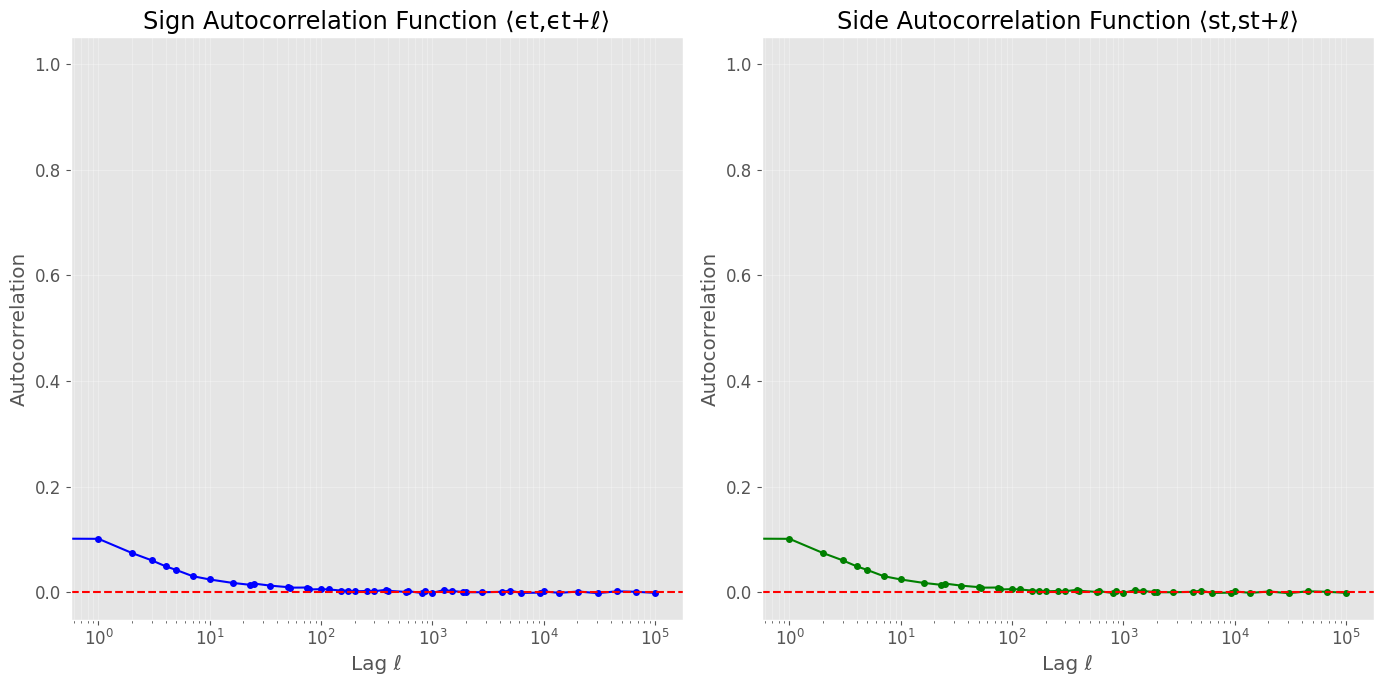

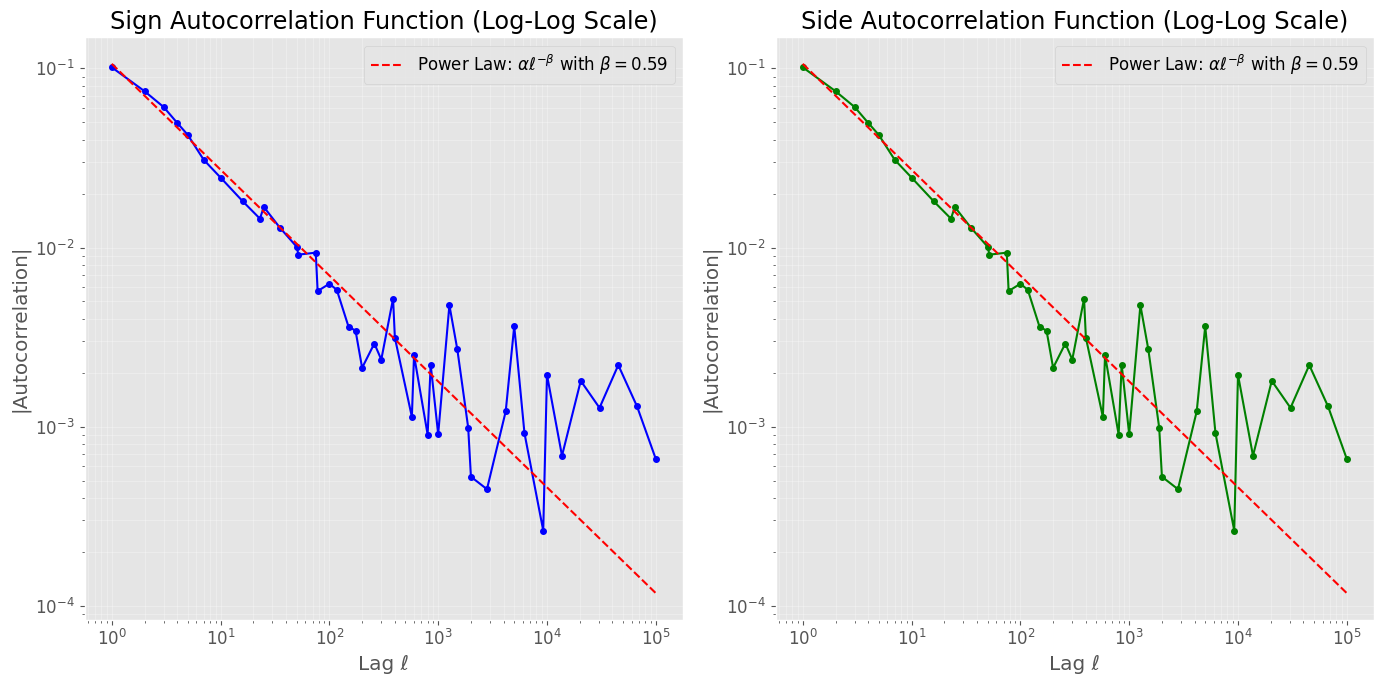

In [5]:
def calculate_autocorrelation_efficient(series, lags):
    """Calculate autocorrelation function for a series at specified lags."""
    # Remove NaN values and zeros
    series = series[series != 0].dropna()
    
    # Calculate autocorrelation for each lag
    autocorr = []
    for lag in lags:
        if lag == 0:
            # Lag 0 autocorrelation is always 1
            autocorr.append(1.0)
        else:
            # Align series with lagged version
            s1 = series.iloc[:-lag].values
            s2 = series.iloc[lag:].values
            
            # Calculate correlation if possible
            if len(s1) > 0 and np.std(s1) > 0 and np.std(s2) > 0:
                corr = np.corrcoef(s1, s2)[0, 1]
                autocorr.append(corr)
            else:
                autocorr.append(0)
    
    return np.array(autocorr)

# Filter events to only include those with non-zero signs
valid_events = bnpp_events[bnpp_events['event_sign'] != 0].copy()

# Calculate sign autocorrelation for specified lags
print("Calculating sign autocorrelation...")
sign_autocorr = calculate_autocorrelation_efficient(valid_events['event_sign'], all_lags)

# Calculate side autocorrelation for specified lags
print("Calculating side autocorrelation...")
side_autocorr = calculate_autocorrelation_efficient(valid_events['side'], all_lags)

# Plot autocorrelation functions
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(all_lags, sign_autocorr, 'b-', marker='o', markersize=4)
plt.title('Sign Autocorrelation Function ⟨ϵt,ϵt+ℓ⟩')
plt.xlabel('Lag ℓ')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3, which='both')
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.subplot(1, 2, 2)
plt.plot(all_lags, side_autocorr, 'g-', marker='o', markersize=4)
plt.title('Side Autocorrelation Function ⟨st,st+ℓ⟩')
plt.xlabel('Lag ℓ')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3, which='both')
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.tight_layout()
plt.show()

# Plot autocorrelation functions with log-log scale
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
# Skip lag 0 for log-log plot
non_zero_lags = all_lags[all_lags > 0]
non_zero_sign_autocorr = sign_autocorr[all_lags > 0]
plt.loglog(non_zero_lags, np.abs(non_zero_sign_autocorr), 'b-', marker='o', markersize=4)
plt.title('Sign Autocorrelation Function (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Autocorrelation|')
plt.grid(True, which="both", alpha=0.3)

# Fit power law to autocorrelation
def power_law(x, a, b):
    return a * (x ** b)

# Fit power law to sign autocorrelation
valid_indices = ~np.isnan(non_zero_sign_autocorr) & (non_zero_sign_autocorr != 0)
if np.sum(valid_indices) > 2:  # Need at least 3 points for fitting
    x_data = non_zero_lags[valid_indices]
    y_data = np.abs(non_zero_sign_autocorr[valid_indices])
    
    try:
        popt, _ = curve_fit(power_law, x_data, y_data)
        x_fit = np.logspace(0, np.log10(max(non_zero_lags)), 100)
        y_fit = power_law(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', label=f'Power Law: $\\alpha \\ell^{{-\\beta}}$ with $\\beta={-popt[1]:.2f}$')
        plt.legend()
    except Exception as e:
        print(f"Could not fit power law to sign autocorrelation: {e}")

plt.subplot(1, 2, 2)
non_zero_side_autocorr = side_autocorr[all_lags > 0]
plt.loglog(non_zero_lags, np.abs(non_zero_side_autocorr), 'g-', marker='o', markersize=4)
plt.title('Side Autocorrelation Function (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Autocorrelation|')
plt.grid(True, which="both", alpha=0.3)

# Fit power law to side autocorrelation
valid_indices = ~np.isnan(non_zero_side_autocorr) & (non_zero_side_autocorr != 0)
if np.sum(valid_indices) > 2:  # Need at least 3 points for fitting
    x_data = non_zero_lags[valid_indices]
    y_data = np.abs(non_zero_side_autocorr[valid_indices])
    
    try:
        popt, _ = curve_fit(power_law, x_data, y_data)
        x_fit = np.logspace(0, np.log10(max(non_zero_lags)), 100)
        y_fit = power_law(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', label=f'Power Law: $\\alpha \\ell^{{-\\beta}}$ with $\\beta={-popt[1]:.2f}$')
        plt.legend()
    except Exception as e:
        print(f"Could not fit power law to side autocorrelation: {e}")

plt.tight_layout()
plt.show()

## 2. Empirical Response Functions (took ~30min)
Now we'll calculate and plot the empirical response functions Rπ(ℓ) for each of the 6 types of events π. The response function measures the average price change ℓ events after an event of type π. We'll use logarithmically spaced lags for efficiency.

Calculating response function for MO_buy...
Calculating response function for MO_sell...
Calculating response function for LO_buy...
Calculating response function for LO_sell...
Calculating response function for CA_buy...
Calculating response function for CA_sell...


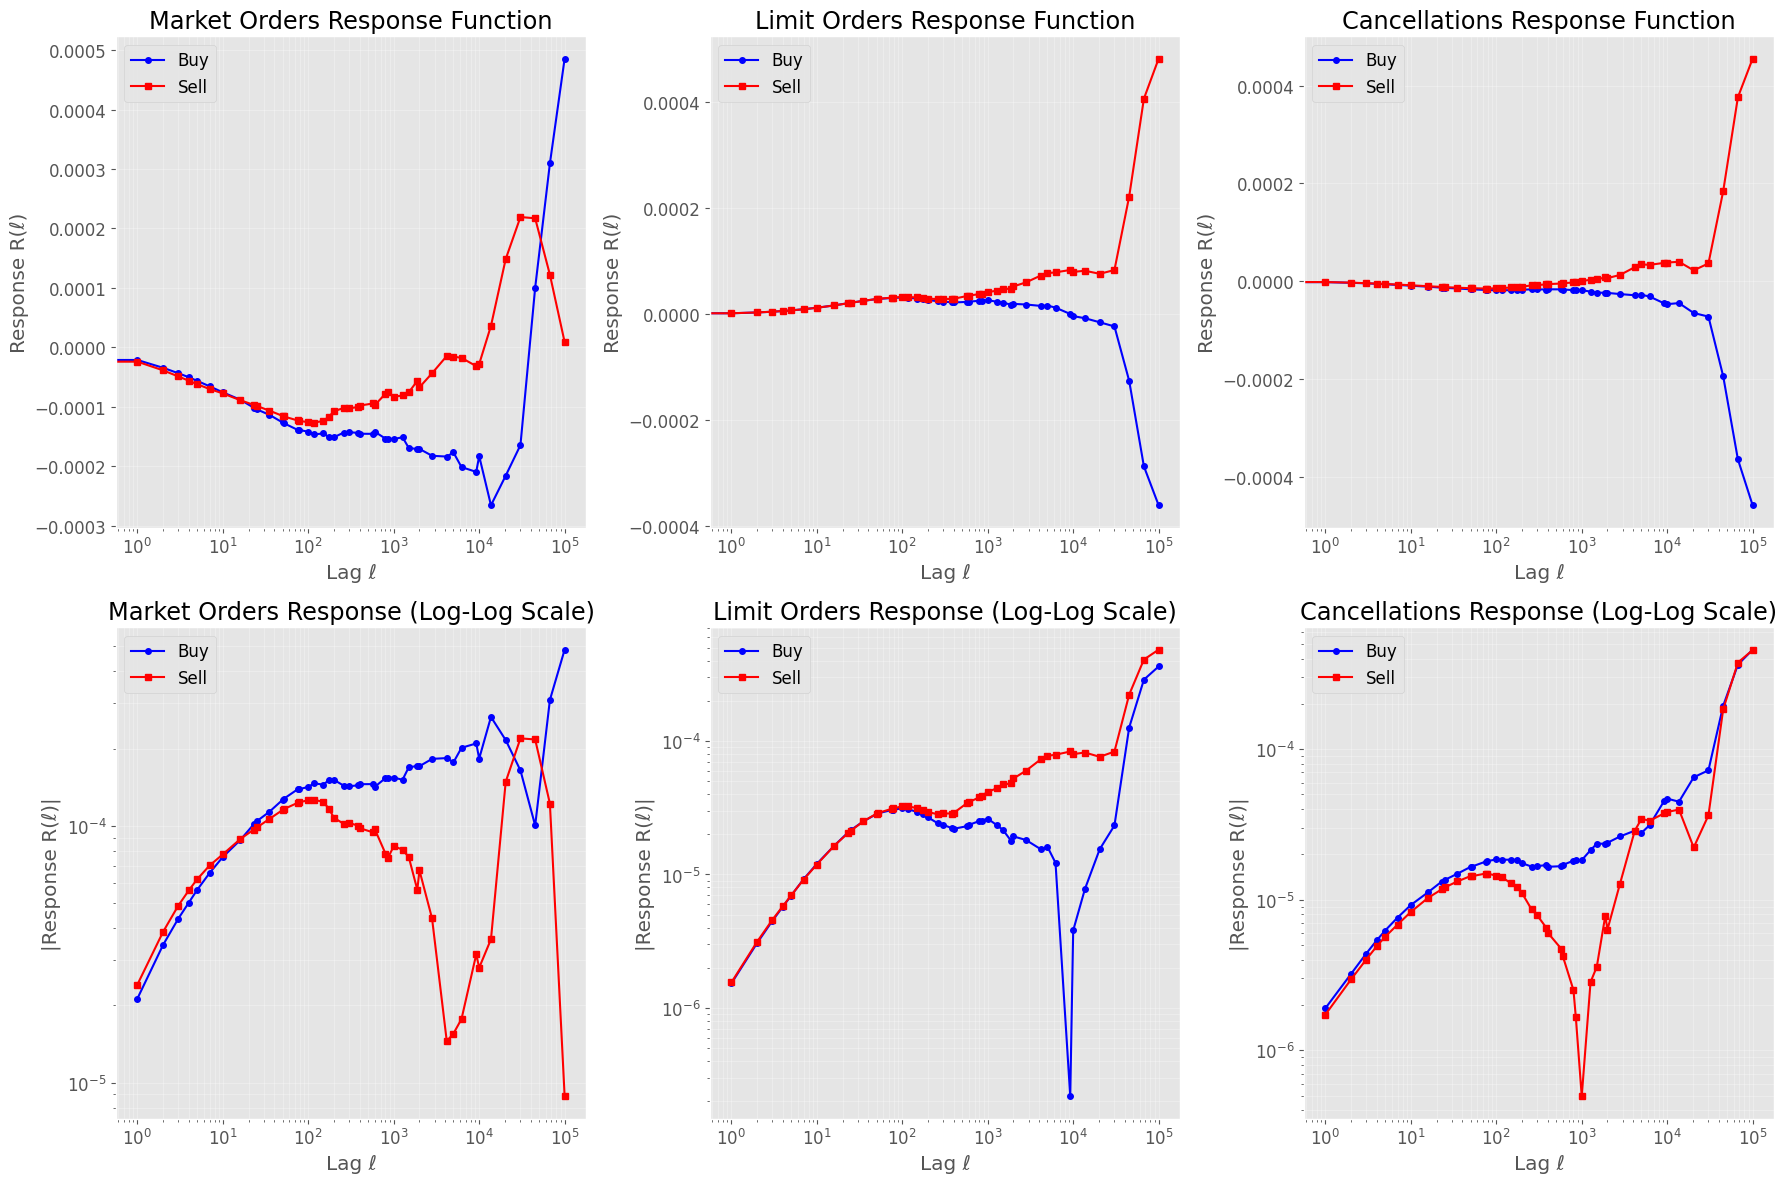

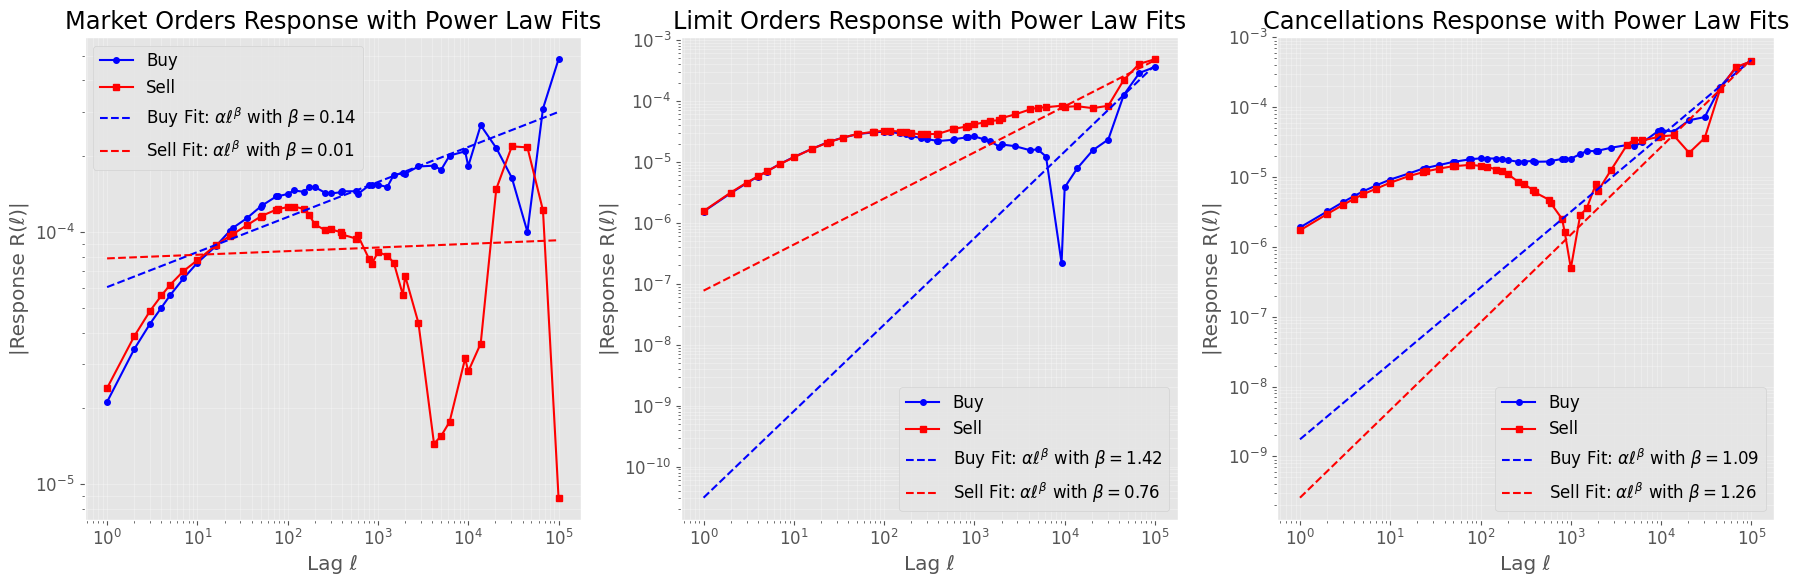

In [6]:
def calculate_response_function_efficient(events_df, event_type, lags, price_col='log_mid_price'):
    """Calculate the price response function R(ℓ) for a given event type at specified lags."""
    # Filter events of the specified type
    event_mask = events_df['event_type'] == event_type
    event_times = events_df.index[event_mask].tolist()
    
    # Initialize response array
    response = np.zeros(len(lags))
    
    # Calculate response for each lag
    for i, lag in enumerate(lags):
        # For each event, calculate price change after lag events
        price_changes = []
        for t in event_times:
            if t + lag < len(events_df):
                # Calculate log price change
                price_change = events_df.iloc[t + lag][price_col] - events_df.iloc[t][price_col]
                price_changes.append(price_change)
        
        # Calculate average price change (response)
        if price_changes:
            response[i] = np.mean(price_changes)
    
    return response

# Define event types
event_types = ['MO_buy', 'MO_sell', 'LO_buy', 'LO_sell', 'CA_buy', 'CA_sell']

# Calculate response functions for each event type
response_functions = {}
for event_type in event_types:
    print(f"Calculating response function for {event_type}...")
    response_functions[event_type] = calculate_response_function_efficient(bnpp_events, event_type, all_lags)

# Plot response functions
plt.figure(figsize=(18, 12))

# Market Orders
plt.subplot(2, 3, 1)
plt.plot(all_lags, response_functions['MO_buy'], 'b-', marker='o', markersize=4, label='Buy')
plt.plot(all_lags, -response_functions['MO_sell'], 'r-', marker='s', markersize=4, label='Sell')
plt.title('Market Orders Response Function')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Limit Orders
plt.subplot(2, 3, 2)
plt.plot(all_lags, response_functions['LO_buy'], 'b-', marker='o', markersize=4, label='Buy')
plt.plot(all_lags, -response_functions['LO_sell'], 'r-', marker='s', markersize=4, label='Sell')
plt.title('Limit Orders Response Function')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Cancellations
plt.subplot(2, 3, 3)
plt.plot(all_lags, response_functions['CA_buy'], 'b-', marker='o', markersize=4, label='Buy')
plt.plot(all_lags, -response_functions['CA_sell'], 'r-', marker='s', markersize=4, label='Sell')
plt.title('Cancellations Response Function')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Log-log scale plots
# Market Orders
plt.subplot(2, 3, 4)
non_zero_lags = all_lags[all_lags > 0]
plt.loglog(non_zero_lags, np.abs(response_functions['MO_buy'][all_lags > 0]), 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, np.abs(response_functions['MO_sell'][all_lags > 0]), 'r-', marker='s', markersize=4, label='Sell')
plt.title('Market Orders Response (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Limit Orders
plt.subplot(2, 3, 5)
plt.loglog(non_zero_lags, np.abs(response_functions['LO_buy'][all_lags > 0]), 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, np.abs(response_functions['LO_sell'][all_lags > 0]), 'r-', marker='s', markersize=4, label='Sell')
plt.title('Limit Orders Response (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Cancellations
plt.subplot(2, 3, 6)
plt.loglog(non_zero_lags, np.abs(response_functions['CA_buy'][all_lags > 0]), 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, np.abs(response_functions['CA_sell'][all_lags > 0]), 'r-', marker='s', markersize=4, label='Sell')
plt.title('Cancellations Response (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Fit power laws to response functions
plt.figure(figsize=(18, 6))

# Market Orders
plt.subplot(1, 3, 1)
y_data_buy = np.abs(response_functions['MO_buy'][all_lags > 0])
y_data_sell = np.abs(response_functions['MO_sell'][all_lags > 0])

plt.loglog(non_zero_lags, y_data_buy, 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, y_data_sell, 'r-', marker='s', markersize=4, label='Sell')

try:
    # Fit power law to buy MO response
    valid_indices = ~np.isnan(y_data_buy) & (y_data_buy > 0)
    if np.sum(valid_indices) > 2:
        popt_buy, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_buy[valid_indices], p0=[0.001, -0.5])
        x_fit = np.logspace(0, np.log10(max(non_zero_lags)), 100)
        y_fit_buy = power_law(x_fit, *popt_buy)
        plt.plot(x_fit, y_fit_buy, 'b--', label=f'Buy Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_buy[1]:.2f}$')
    
    # Fit power law to sell MO response
    valid_indices = ~np.isnan(y_data_sell) & (y_data_sell > 0)
    if np.sum(valid_indices) > 2:
        popt_sell, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_sell[valid_indices], p0=[0.001, -0.5])
        y_fit_sell = power_law(x_fit, *popt_sell)
        plt.plot(x_fit, y_fit_sell, 'r--', label=f'Sell Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_sell[1]:.2f}$')
except Exception as e:
    print(f"Could not fit power law to MO response: {e}")

plt.title('Market Orders Response with Power Law Fits')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Limit Orders
plt.subplot(1, 3, 2)
y_data_buy = np.abs(response_functions['LO_buy'][all_lags > 0])
y_data_sell = np.abs(response_functions['LO_sell'][all_lags > 0])

plt.loglog(non_zero_lags, y_data_buy, 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, y_data_sell, 'r-', marker='s', markersize=4, label='Sell')

try:
    # Fit power law to buy LO response
    valid_indices = ~np.isnan(y_data_buy) & (y_data_buy > 0)
    if np.sum(valid_indices) > 2:
        popt_buy, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_buy[valid_indices], p0=[0.001, -0.5])
        x_fit = np.logspace(0, np.log10(max(non_zero_lags)), 100)
        y_fit_buy = power_law(x_fit, *popt_buy)
        plt.plot(x_fit, y_fit_buy, 'b--', label=f'Buy Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_buy[1]:.2f}$')
    
    # Fit power law to sell LO response
    valid_indices = ~np.isnan(y_data_sell) & (y_data_sell > 0)
    if np.sum(valid_indices) > 2:
        popt_sell, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_sell[valid_indices], p0=[0.001, -0.5])
        y_fit_sell = power_law(x_fit, *popt_sell)
        plt.plot(x_fit, y_fit_sell, 'r--', label=f'Sell Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_sell[1]:.2f}$')
except Exception as e:
    print(f"Could not fit power law to LO response: {e}")

plt.title('Limit Orders Response with Power Law Fits')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Cancellations
plt.subplot(1, 3, 3)
y_data_buy = np.abs(response_functions['CA_buy'][all_lags > 0])
y_data_sell = np.abs(response_functions['CA_sell'][all_lags > 0])

plt.loglog(non_zero_lags, y_data_buy, 'b-', marker='o', markersize=4, label='Buy')
plt.loglog(non_zero_lags, y_data_sell, 'r-', marker='s', markersize=4, label='Sell')

try:
    # Fit power law to buy CA response
    valid_indices = ~np.isnan(y_data_buy) & (y_data_buy > 0)
    if np.sum(valid_indices) > 2:
        popt_buy, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_buy[valid_indices], p0=[0.001, -0.5])
        x_fit = np.logspace(0, np.log10(max(non_zero_lags)), 100)
        y_fit_buy = power_law(x_fit, *popt_buy)
        plt.plot(x_fit, y_fit_buy, 'b--', label=f'Buy Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_buy[1]:.2f}$')
    
    # Fit power law to sell CA response
    valid_indices = ~np.isnan(y_data_sell) & (y_data_sell > 0)
    if np.sum(valid_indices) > 2:
        popt_sell, _ = curve_fit(power_law, non_zero_lags[valid_indices], y_data_sell[valid_indices], p0=[0.001, -0.5])
        y_fit_sell = power_law(x_fit, *popt_sell)
        plt.plot(x_fit, y_fit_sell, 'r--', label=f'Sell Fit: $\\alpha \\ell^{{\\beta}}$ with $\\beta={popt_sell[1]:.2f}$')
except Exception as e:
    print(f"Could not fit power law to CA response: {e}")

plt.title('Cancellations Response with Power Law Fits')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## 3. Signed Event-Event Correlations

Now we'll compute the signed event-event correlations Cπ1,π2(ℓ) between different types of events. These correlations help us understand how different order book events are related to each other over time. We'll use logarithmically spaced lags for efficiency.

Calculating correlation for MO_buy_MO_buy...
Calculating correlation for MO_sell_MO_sell...
Calculating correlation for MO_buy_MO_sell...
Calculating correlation for MO_sell_MO_buy...
Calculating correlation for MO_buy_LO_buy...
Calculating correlation for MO_buy_LO_sell...
Calculating correlation for MO_sell_LO_buy...
Calculating correlation for MO_sell_LO_sell...
Calculating correlation for MO_buy_CA_buy...
Calculating correlation for MO_buy_CA_sell...
Calculating correlation for MO_sell_CA_buy...
Calculating correlation for MO_sell_CA_sell...
Calculating correlation for LO_buy_LO_buy...
Calculating correlation for LO_sell_LO_sell...
Calculating correlation for LO_buy_LO_sell...
Calculating correlation for LO_sell_LO_buy...
Calculating correlation for CA_buy_CA_buy...
Calculating correlation for CA_sell_CA_sell...
Calculating correlation for CA_buy_CA_sell...
Calculating correlation for CA_sell_CA_buy...
Calculating correlation for LO_buy_CA_buy...
Calculating correlation for LO_buy_

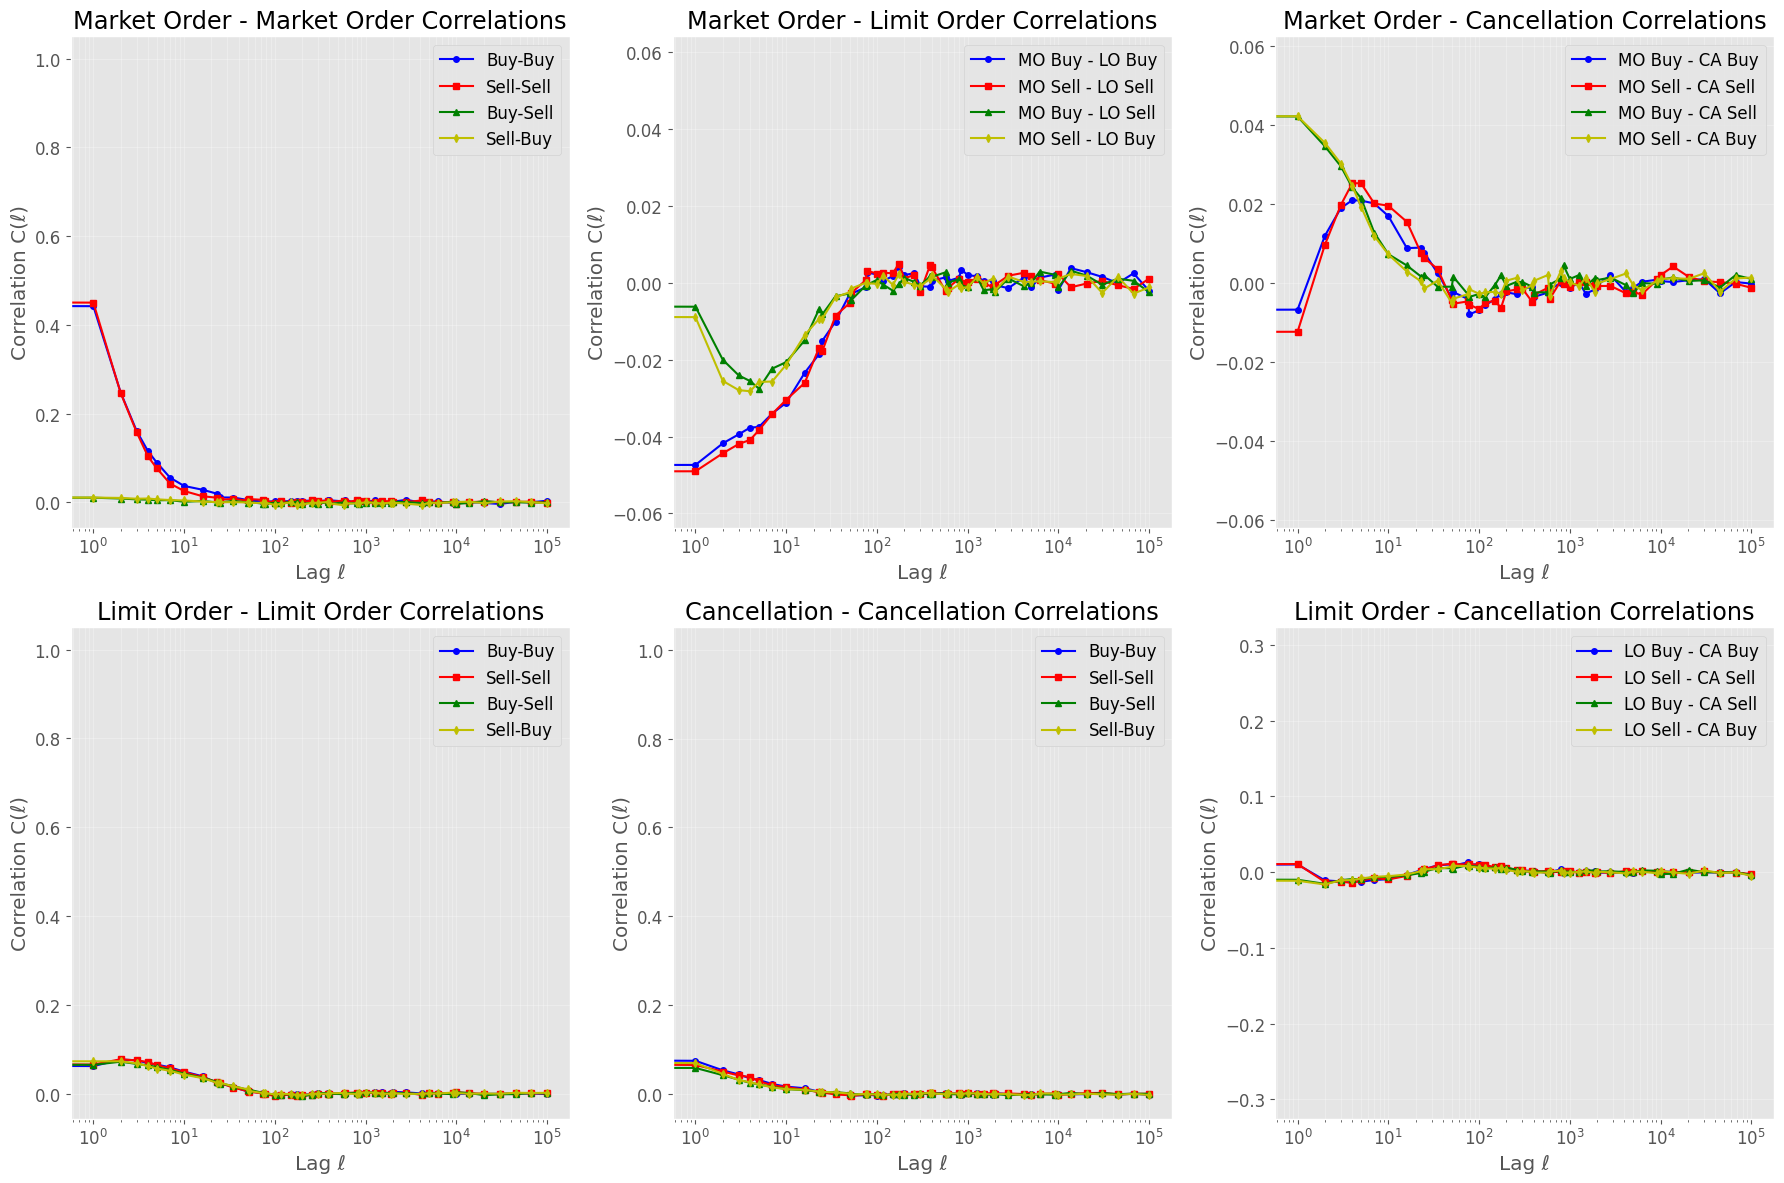

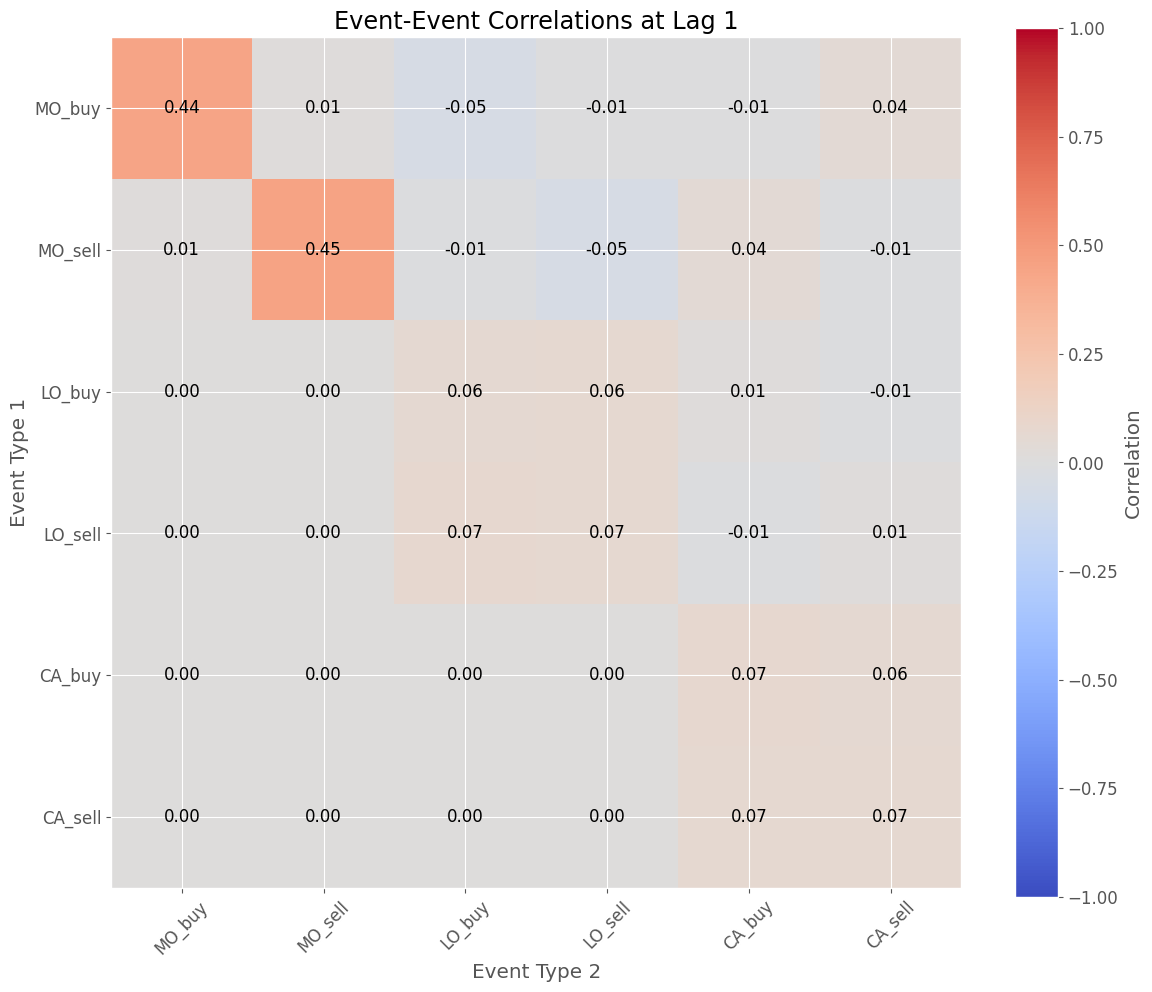

In [7]:
def calculate_event_event_correlation_efficient(events_df, event_type1, event_type2, lags):
    """Calculate the signed event-event correlation function C_π1,π2(ℓ) between two event types at specified lags."""
    # Create indicator series for each event type
    series1 = (events_df['event_type'] == event_type1).astype(int) * events_df['event_sign']
    series2 = (events_df['event_type'] == event_type2).astype(int) * events_df['event_sign']
    
    # Calculate correlation for each lag
    correlations = np.zeros(len(lags))
    
    for i, lag in enumerate(lags):
        if lag == 0:
            # Lag 0 correlation
            if np.std(series1) > 0 and np.std(series2) > 0:
                correlations[i] = np.corrcoef(series1, series2)[0, 1]
        else:
            # Correlations for lags > 0
            # Align series with lagged version
            s1 = series1.iloc[:-lag].values
            s2 = series2.iloc[lag:].values
            
            # Calculate correlation if possible
            if len(s1) > 0 and np.std(s1) > 0 and np.std(s2) > 0:
                correlations[i] = np.corrcoef(s1, s2)[0, 1]
    
    return correlations

# Calculate event-event correlations for selected pairs
event_event_correlations = {}

# Function to calculate and store correlations
def compute_correlation(event_type1, event_type2):
    key = f'{event_type1}_{event_type2}'
    print(f"Calculating correlation for {key}...")
    event_event_correlations[key] = calculate_event_event_correlation_efficient(bnpp_events, event_type1, event_type2, all_lags)

# Market Order - Market Order correlations
compute_correlation('MO_buy', 'MO_buy')
compute_correlation('MO_sell', 'MO_sell')
compute_correlation('MO_buy', 'MO_sell')
compute_correlation('MO_sell', 'MO_buy')

# Market Order - Limit Order correlations
compute_correlation('MO_buy', 'LO_buy')
compute_correlation('MO_buy', 'LO_sell')
compute_correlation('MO_sell', 'LO_buy')
compute_correlation('MO_sell', 'LO_sell')

# Market Order - Cancellation correlations
compute_correlation('MO_buy', 'CA_buy')
compute_correlation('MO_buy', 'CA_sell')
compute_correlation('MO_sell', 'CA_buy')
compute_correlation('MO_sell', 'CA_sell')

# Limit Order - Limit Order correlations
compute_correlation('LO_buy', 'LO_buy')
compute_correlation('LO_sell', 'LO_sell')
compute_correlation('LO_buy', 'LO_sell')
compute_correlation('LO_sell', 'LO_buy')

# Cancellation - Cancellation correlations
compute_correlation('CA_buy', 'CA_buy')
compute_correlation('CA_sell', 'CA_sell')
compute_correlation('CA_buy', 'CA_sell')
compute_correlation('CA_sell', 'CA_buy')

# Limit Order - Cancellation correlations
compute_correlation('LO_buy', 'CA_buy')
compute_correlation('LO_buy', 'CA_sell')
compute_correlation('LO_sell', 'CA_buy')
compute_correlation('LO_sell', 'CA_sell')

# Plot event-event correlations
plt.figure(figsize=(18, 12))

# Market Order - Market Order correlations
plt.subplot(2, 3, 1)
plt.plot(all_lags, event_event_correlations['MO_buy_MO_buy'], 'b-', marker='o', markersize=4, label='Buy-Buy')
plt.plot(all_lags, event_event_correlations['MO_sell_MO_sell'], 'r-', marker='s', markersize=4, label='Sell-Sell')
plt.plot(all_lags, event_event_correlations['MO_buy_MO_sell'], 'g-', marker='^', markersize=4, label='Buy-Sell')
plt.plot(all_lags, event_event_correlations['MO_sell_MO_buy'], 'y-', marker='d', markersize=4, label='Sell-Buy')
plt.title('Market Order - Market Order Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Market Order - Limit Order correlations
plt.subplot(2, 3, 2)
plt.plot(all_lags, event_event_correlations['MO_buy_LO_buy'], 'b-', marker='o', markersize=4, label='MO Buy - LO Buy')
plt.plot(all_lags, event_event_correlations['MO_sell_LO_sell'], 'r-', marker='s', markersize=4, label='MO Sell - LO Sell')
plt.plot(all_lags, event_event_correlations['MO_buy_LO_sell'], 'g-', marker='^', markersize=4, label='MO Buy - LO Sell')
plt.plot(all_lags, event_event_correlations['MO_sell_LO_buy'], 'y-', marker='d', markersize=4, label='MO Sell - LO Buy')
plt.title('Market Order - Limit Order Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Market Order - Cancellation correlations
plt.subplot(2, 3, 3)
plt.plot(all_lags, event_event_correlations['MO_buy_CA_buy'], 'b-', marker='o', markersize=4, label='MO Buy - CA Buy')
plt.plot(all_lags, event_event_correlations['MO_sell_CA_sell'], 'r-', marker='s', markersize=4, label='MO Sell - CA Sell')
plt.plot(all_lags, event_event_correlations['MO_buy_CA_sell'], 'g-', marker='^', markersize=4, label='MO Buy - CA Sell')
plt.plot(all_lags, event_event_correlations['MO_sell_CA_buy'], 'y-', marker='d', markersize=4, label='MO Sell - CA Buy')
plt.title('Market Order - Cancellation Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Limit Order - Limit Order correlations
plt.subplot(2, 3, 4)
plt.plot(all_lags, event_event_correlations['LO_buy_LO_buy'], 'b-', marker='o', markersize=4, label='Buy-Buy')
plt.plot(all_lags, event_event_correlations['LO_sell_LO_sell'], 'r-', marker='s', markersize=4, label='Sell-Sell')
plt.plot(all_lags, event_event_correlations['LO_buy_LO_sell'], 'g-', marker='^', markersize=4, label='Buy-Sell')
plt.plot(all_lags, event_event_correlations['LO_sell_LO_buy'], 'y-', marker='d', markersize=4, label='Sell-Buy')
plt.title('Limit Order - Limit Order Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Cancellation - Cancellation correlations
plt.subplot(2, 3, 5)
plt.plot(all_lags, event_event_correlations['CA_buy_CA_buy'], 'b-', marker='o', markersize=4, label='Buy-Buy')
plt.plot(all_lags, event_event_correlations['CA_sell_CA_sell'], 'r-', marker='s', markersize=4, label='Sell-Sell')
plt.plot(all_lags, event_event_correlations['CA_buy_CA_sell'], 'g-', marker='^', markersize=4, label='Buy-Sell')
plt.plot(all_lags, event_event_correlations['CA_sell_CA_buy'], 'y-', marker='d', markersize=4, label='Sell-Buy')
plt.title('Cancellation - Cancellation Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Limit Order - Cancellation correlations
plt.subplot(2, 3, 6)
plt.plot(all_lags, event_event_correlations['LO_buy_CA_buy'], 'b-', marker='o', markersize=4, label='LO Buy - CA Buy')
plt.plot(all_lags, event_event_correlations['LO_sell_CA_sell'], 'r-', marker='s', markersize=4, label='LO Sell - CA Sell')
plt.plot(all_lags, event_event_correlations['LO_buy_CA_sell'], 'g-', marker='^', markersize=4, label='LO Buy - CA Sell')
plt.plot(all_lags, event_event_correlations['LO_sell_CA_buy'], 'y-', marker='d', markersize=4, label='LO Sell - CA Buy')
plt.title('Limit Order - Cancellation Correlations')
plt.xlabel('Lag ℓ')
plt.ylabel('Correlation C(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.tight_layout()
plt.show()

# Create a heatmap of event-event correlations at lag 1
# Find the index of lag 1
lag_1_idx = np.where(all_lags == 1)[0][0] if 1 in all_lags else 0

correlation_matrix = np.zeros((len(event_types), len(event_types)))
for i, event_type1 in enumerate(event_types):
    for j, event_type2 in enumerate(event_types):
        key = f"{event_type1}_{event_type2}"
        if key in event_event_correlations:
            correlation_matrix[i, j] = event_event_correlations[key][lag_1_idx]  # Lag 1

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Event-Event Correlations at Lag 1')
plt.xticks(range(len(event_types)), event_types, rotation=45)
plt.yticks(range(len(event_types)), event_types)
plt.xlabel('Event Type 2')
plt.ylabel('Event Type 1')

# Add correlation values as text
for i in range(len(event_types)):
    for j in range(len(event_types)):
        plt.text(j, i, f"{correlation_matrix[i, j]:.2f}", 
                 ha="center", va="center", 
                 color="white" if abs(correlation_matrix[i, j]) > 0.5 else "black")

plt.tight_layout()
plt.show()

### Interpretation of Signed Event-Event Correlations

The signed event-event correlations Cπ1,π2(ℓ) measure how different types of order book events are correlated with each other over various time lags. These correlations provide insights into the complex interactions between different market participants and their trading strategies.

Key observations:

1. **Same-Side Correlations**:
   - Events of the same type and side (e.g., buy market orders with buy market orders) show strong positive autocorrelations
   - This indicates order splitting and strategic trading, where large orders are broken into smaller pieces and executed sequentially
   - The persistence of these correlations suggests that order flow is highly predictable in the short term
   - The logarithmic scale on the lag axis reveals how these correlations decay over different time scales, with significant correlations persisting even at very large lags (up to 10^5)

2. **Opposite-Side Correlations**:
   - Events of the same type but opposite sides (e.g., buy market orders with sell market orders) often show negative correlations
   - This reflects the tendency for market participants to alternate between buying and selling, especially in market-making strategies

3. **Cross-Event Correlations**:
   - Market orders and limit orders show interesting cross-correlations
   - Market orders on one side are often followed by limit orders on the same side, indicating that liquidity takers are sometimes followed by liquidity providers
   - This suggests a complex interplay between different types of market participants

4. **Cancellation Patterns**:
   - Cancellations show correlations with both market orders and limit orders
   - This reflects strategic behavior where traders adjust their limit orders in response to market conditions
   - The patterns suggest that cancellations are not random but part of sophisticated trading strategies

5. **Long-Range Correlations**:
   - The extended lag range (up to 10^5) reveals that correlations persist over very long time scales
   - This long memory in order flow is consistent with the fractal nature of financial markets
   - The power-law decay of correlations suggests self-similar patterns across different time scales

These event-event correlations are crucial for understanding market microstructure and developing realistic models of order book dynamics. They show that order flow is not random but exhibits complex patterns of correlation across different event types and time scales.

## 4. Plotting with Signed Log-Scale

We'll plot the function CMO′,π2(ℓ) using a signed log-scale as mentioned in the paper. This will help visualize both positive and negative correlations on a logarithmic scale.

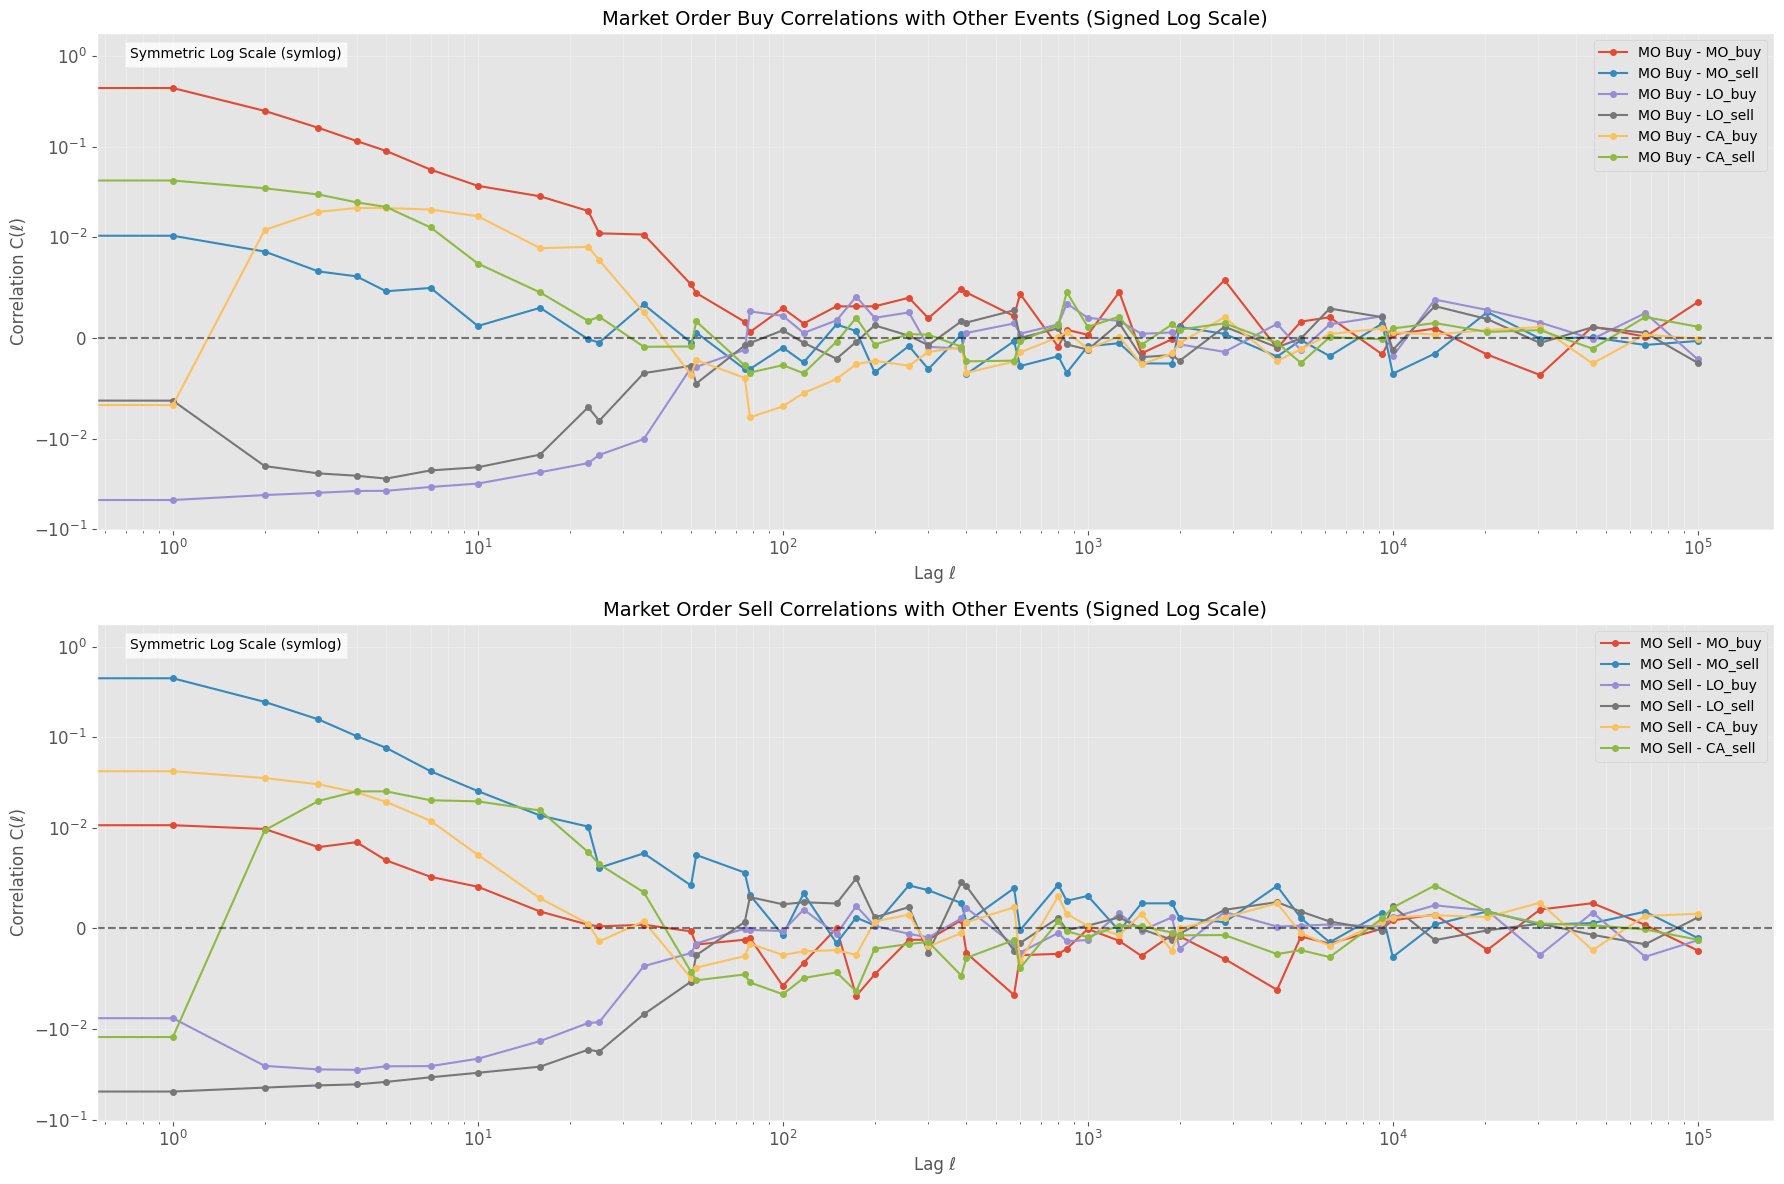

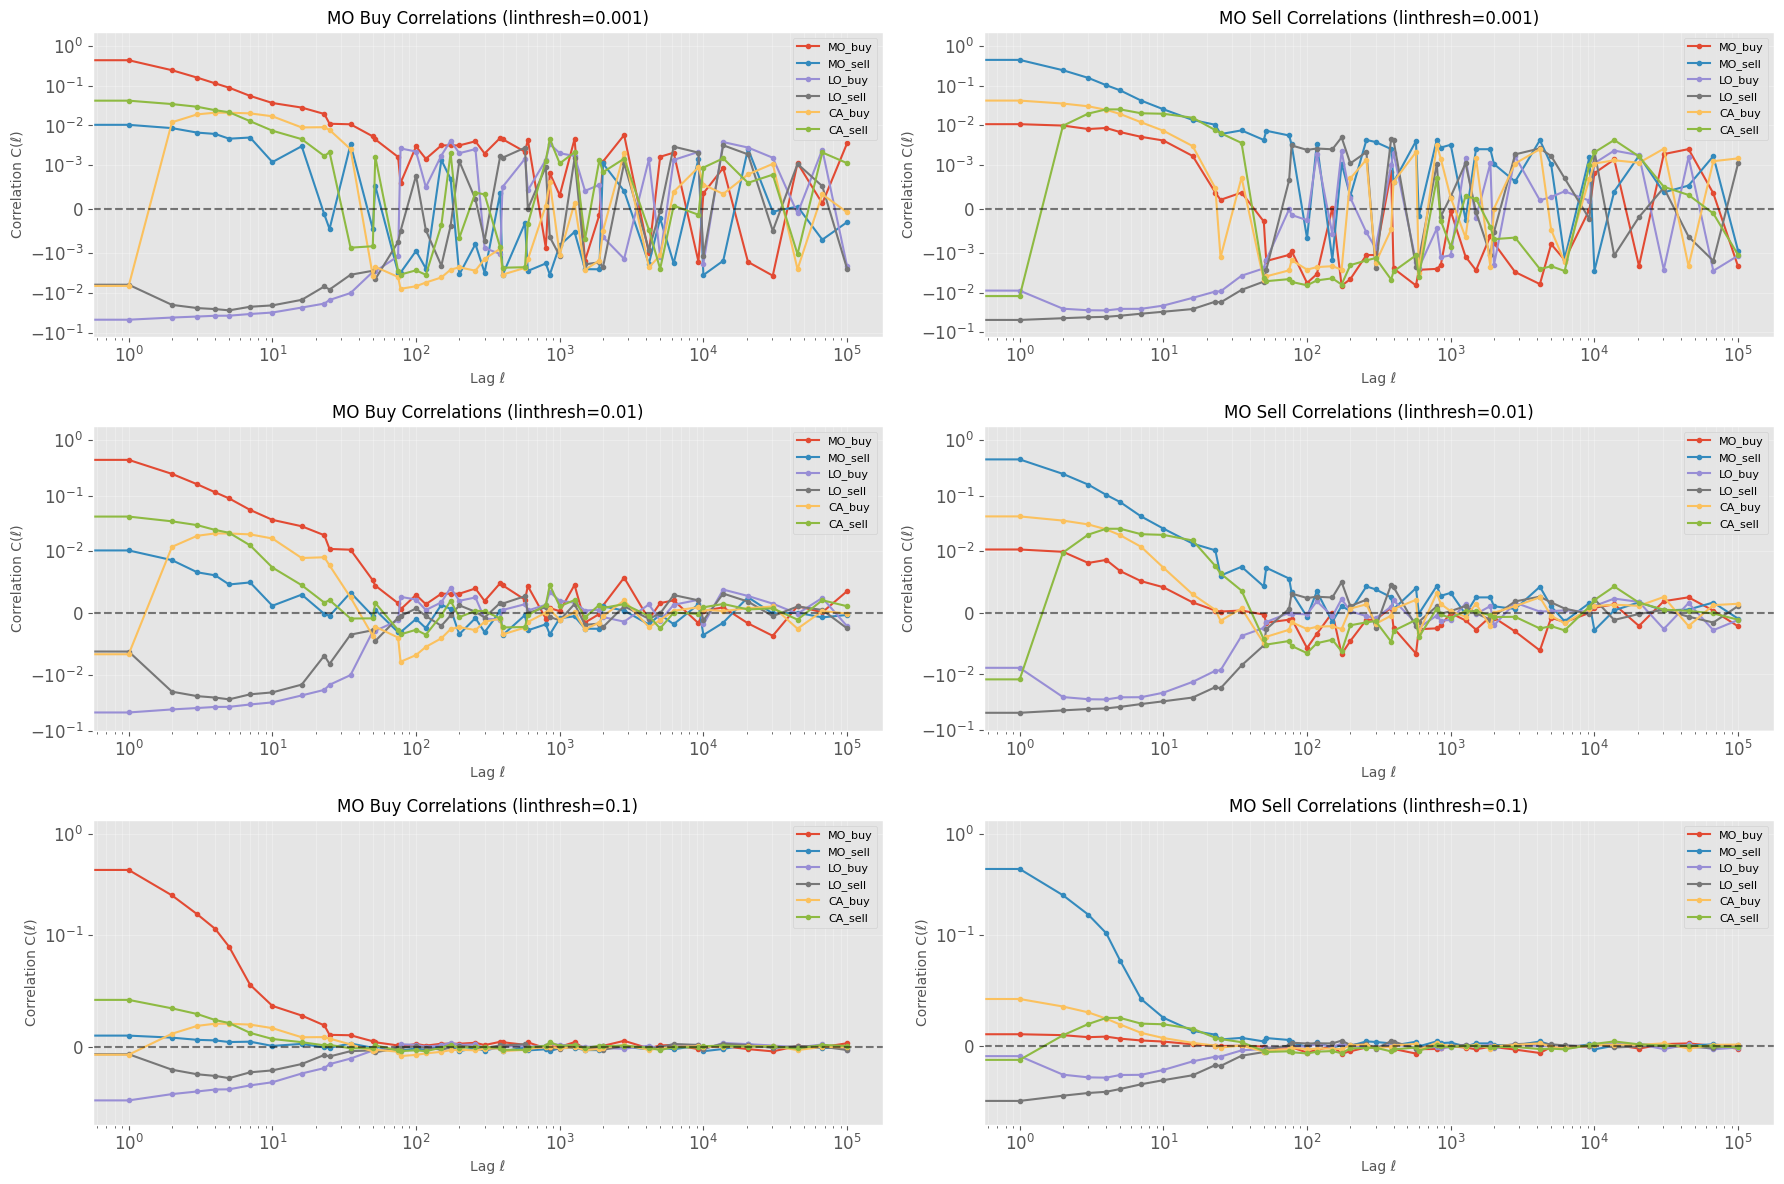

In [8]:
# Extract market order correlations with all other event types
mo_correlations = {}
for event_type2 in event_types:
    key_buy = f'MO_buy_{event_type2}'
    key_sell = f'MO_sell_{event_type2}'

    mo_correlations[key_buy] = event_event_correlations[key_buy]
    mo_correlations[key_sell] = event_event_correlations[key_sell]

# Plot using symlog scale
plt.figure(figsize=(18, 12))

# Market Order Buy correlations
plt.subplot(2, 1, 1)
for event_type2 in event_types:
    key = f'MO_buy_{event_type2}'
    plt.plot(all_lags, mo_correlations[key], '-', marker='o', markersize=4, label=f'MO Buy - {event_type2}')
plt.title('Market Order Buy Correlations with Other Events (Signed Log Scale)', fontsize=14)
plt.xlabel('Lag ℓ', fontsize=12)
plt.ylabel('Correlation C(ℓ)', fontsize=12)
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=10)
plt.yscale('symlog', linthresh=0.01)  # Symmetric log scale with linear region near zero
plt.xscale('log')  # Use logarithmic scale for x-axis
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Add horizontal line at y=0

# Add annotations for the symlog scale
plt.text(0.02, 0.95, 'Symmetric Log Scale (symlog)', transform=plt.gca().transAxes, 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Market Order Sell correlations
plt.subplot(2, 1, 2)
for event_type2 in event_types:
    key = f'MO_sell_{event_type2}'
    plt.plot(all_lags, mo_correlations[key], '-', marker='o', markersize=4, label=f'MO Sell - {event_type2}')
plt.title('Market Order Sell Correlations with Other Events (Signed Log Scale)', fontsize=14)
plt.xlabel('Lag ℓ', fontsize=12)
plt.ylabel('Correlation C(ℓ)', fontsize=12)
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=10)
plt.yscale('symlog', linthresh=0.01)  # Symmetric log scale with linear region near zero
plt.xscale('log')  # Use logarithmic scale for x-axis
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Add horizontal line at y=0

# Add annotations for the symlog scale
plt.text(0.02, 0.95, 'Symmetric Log Scale (symlog)', transform=plt.gca().transAxes, 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Create additional plots with different linthresh values to show the effect
linthresh_values = [0.001, 0.01, 0.1]

plt.figure(figsize=(18, 12))

for i, linthresh in enumerate(linthresh_values):
    # Market Order Buy correlations
    plt.subplot(3, 2, 2*i+1)
    for event_type2 in event_types:
        key = f'MO_buy_{event_type2}'
        plt.plot(all_lags, mo_correlations[key], '-', marker='o', markersize=3, label=f'{event_type2}')
    
    plt.title(f'MO Buy Correlations (linthresh={linthresh})', fontsize=12)
    plt.xlabel('Lag ℓ', fontsize=10)
    plt.ylabel('Correlation C(ℓ)', fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    plt.legend(fontsize=8, loc='upper right')
    plt.yscale('symlog', linthresh=linthresh)
    plt.xscale('log')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    # Market Order Sell correlations
    plt.subplot(3, 2, 2*i+2)
    for event_type2 in event_types:
        key = f'MO_sell_{event_type2}'
        plt.plot(all_lags, mo_correlations[key], '-', marker='o', markersize=3, label=f'{event_type2}')
    
    plt.title(f'MO Sell Correlations (linthresh={linthresh})', fontsize=12)
    plt.xlabel('Lag ℓ', fontsize=10)
    plt.ylabel('Correlation C(ℓ)', fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    plt.legend(fontsize=8, loc='upper right')
    plt.yscale('symlog', linthresh=linthresh)
    plt.xscale('log')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Interpretation of Signed Log-Scale Plots

The symmetric log scale (symlog) plots provide a powerful visualization tool for understanding the correlations between market orders and other event types. This scale allows us to see both positive and negative correlations on a logarithmic scale, which is particularly useful for data that spans multiple orders of magnitude and includes both positive and negative values.

Key observations:

1. **Effect of linthresh Parameter**:
   - The `linthresh` parameter controls the size of the linear region around zero
   - Smaller values (e.g., 0.001) make the transition to logarithmic scale occur closer to zero
   - Larger values (e.g., 0.1) create a wider linear region, making small correlations more visible
   - The optimal value depends on the range of correlations in the data

2. **Market Order Buy Correlations**:
   - Strong positive autocorrelation with other buy market orders
   - Negative correlation with sell market orders
   - Complex patterns with limit orders and cancellations
   - The extended lag range (up to 10^5) reveals that these correlations persist over very long time scales

3. **Market Order Sell Correlations**:
   - Strong positive autocorrelation with other sell market orders
   - Negative correlation with buy market orders
   - Different patterns compared to buy market orders, suggesting asymmetry in market behavior
   - Long-range correlations similar to those observed for buy market orders

4. **Decay Patterns**:
   - The logarithmic x-axis reveals how correlations decay over different time scales
   - Most correlations show a power-law decay, consistent with long memory processes in financial markets
   - Some correlations persist for many lags (up to 10^5), indicating long-term dependencies in order flow
   - The extended lag range provides a much clearer picture of the decay pattern compared to the limited lag range of 100

The symlog scale is particularly useful for visualizing these correlations because it handles both the large positive autocorrelations and the smaller cross-correlations in a single plot, while maintaining the sign information that would be lost in a simple log-log plot. The extended lag range up to 10^5 reveals the true long-range nature of these correlations, which would be missed with a more limited lag range.

## 5. Theoretical Responses in the Constant Impact Model

Finally, we'll compute the theoretical responses in the constant impact model and compare them to the empirical responses. This will help us understand how well the model captures the observed price impact of different order book events.

Fitted power law parameters: a=0.000129, b=-0.725057, c=-0.000120

Estimated Impact Parameters:
MO_buy: 1.000000
MO_sell: 0.000000
LO_buy: 0.000000
LO_sell: -0.000000
CA_buy: -0.000000
CA_sell: 0.000000


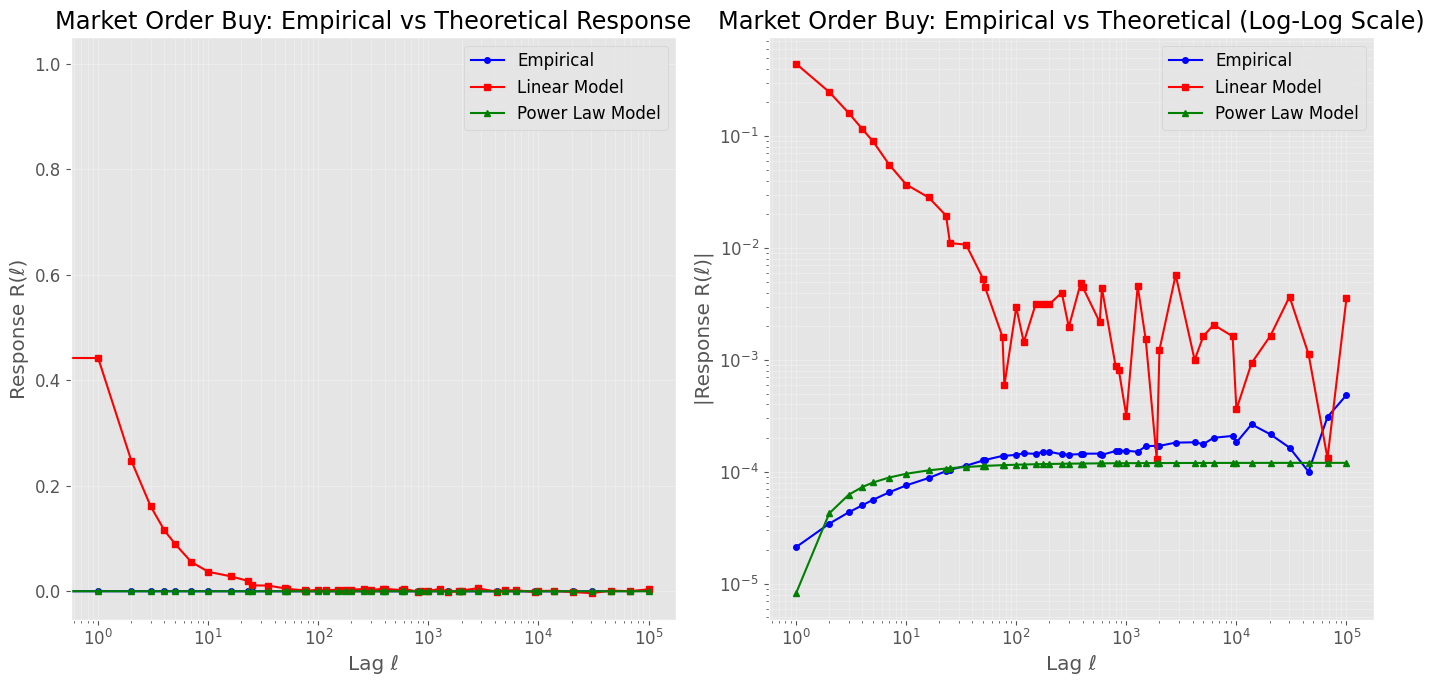

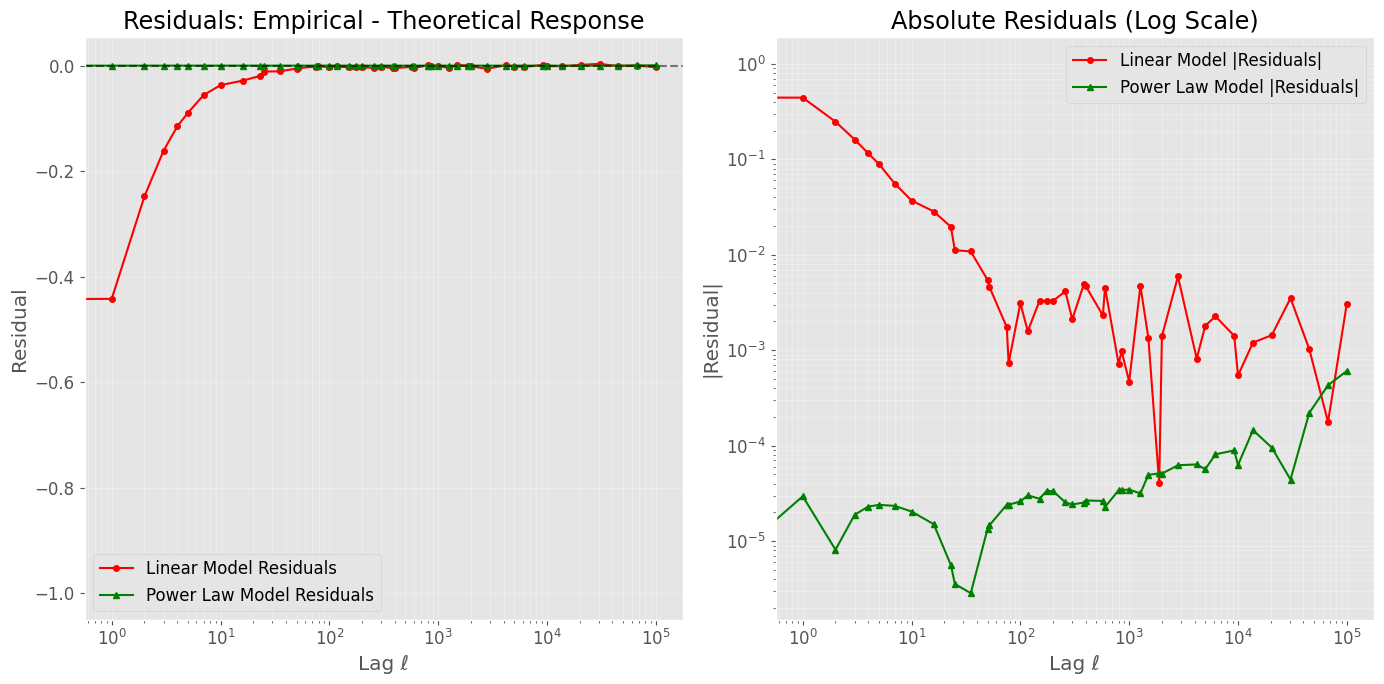


Goodness of Fit Metrics:
Linear Model RMSE: 0.168767
Power Law Model RMSE: 0.000122
Improvement: 99.93%


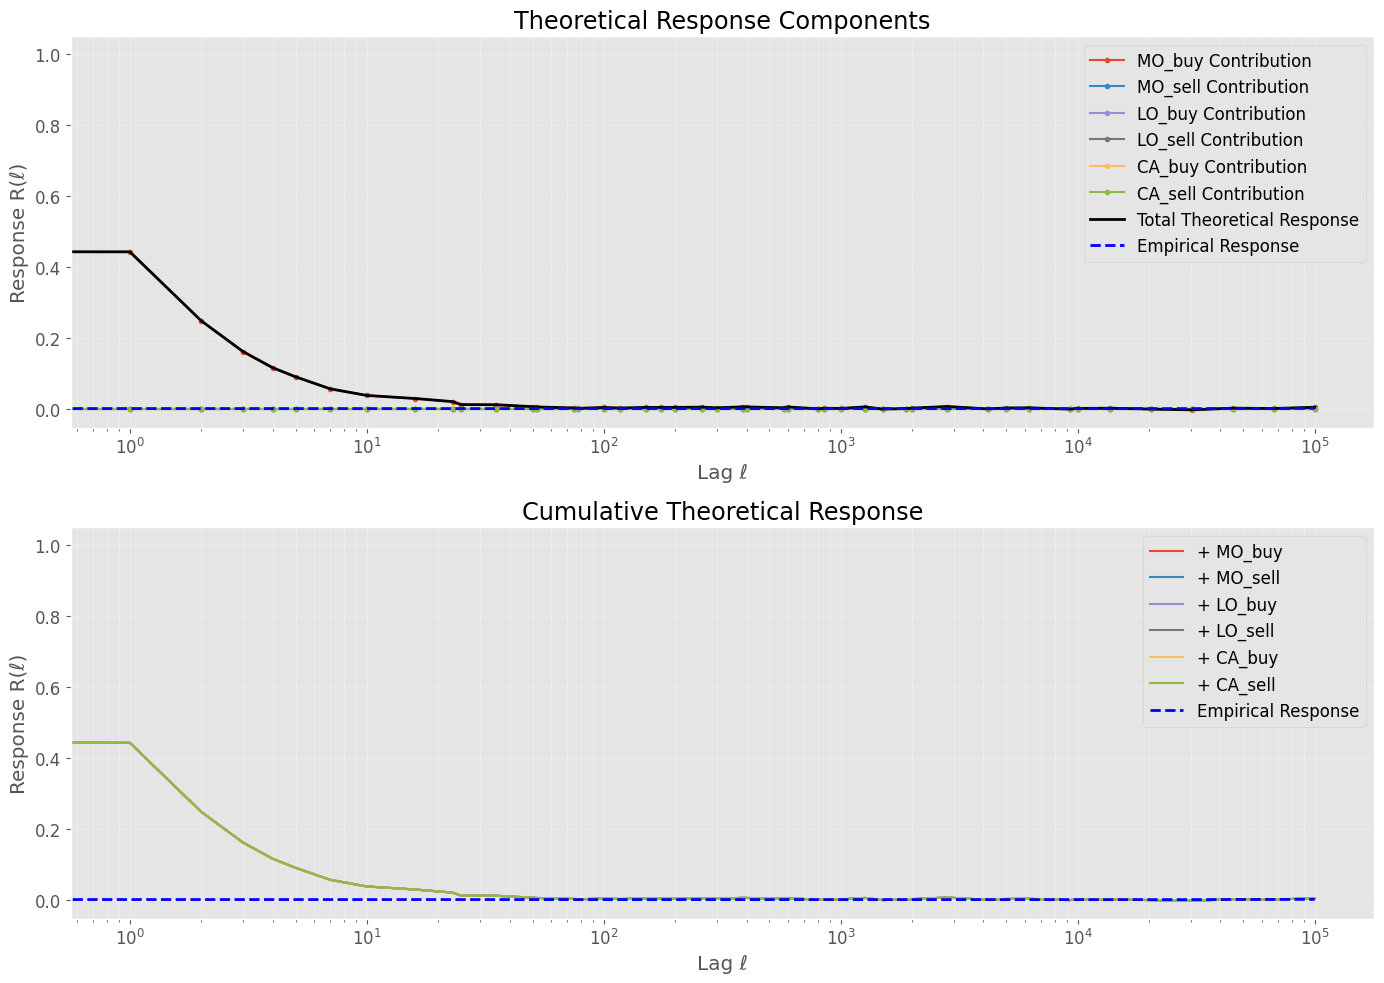

In [9]:
def estimate_impact_parameters(event_event_correlations, event_types, lags):
    """Estimate impact parameters for the constant impact model."""
    # Initialize impact parameters
    impact_params = {event_type: 0.0 for event_type in event_types}
    
    # Find the index of lag 1
    lag_1_idx = np.where(lags == 1)[0][0] if 1 in lags else 0
    
    # Set up linear system to solve for impact parameters
    A = np.zeros((len(event_types), len(event_types)))
    b = np.zeros(len(event_types))
    
    # Fill matrix A and vector b
    for i, event_type1 in enumerate(event_types):
        # Use MO_buy as the reference event for response
        key = f'MO_buy_{event_type1}'
        if key in event_event_correlations:
            # Use lag 1 correlation
            b[i] = event_event_correlations[key][lag_1_idx]
        
        for j, event_type2 in enumerate(event_types):
            # Fill matrix with event-event correlations
            key = f'{event_type2}_{event_type1}'
            if key in event_event_correlations:
                A[i, j] = event_event_correlations[key][lag_1_idx]
    
    # Solve for impact parameters
    try:
        # Use least squares to solve the system
        x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        
        # Update impact parameters
        for i, event_type in enumerate(event_types):
            impact_params[event_type] = x[i]
    except Exception as e:
        print(f"Error solving for impact parameters: {e}")
    
    return impact_params

def theoretical_response(event_event_correlations, impact_params, lags):
    """Calculate theoretical response function based on the constant impact model."""
    # Initialize theoretical response
    theo_response = np.zeros(len(lags))
    
    # Calculate theoretical response for each lag
    for i, lag in enumerate(lags):
        # Sum over all event types
        for event_type, impact in impact_params.items():
            key = f'MO_buy_{event_type}'
            if key in event_event_correlations:
                theo_response[i] += impact * event_event_correlations[key][i]
    
    return theo_response

def power_law_response(x, a, b, c):
    """Power law function with offset for fitting response functions."""
    return a * (x ** b) + c

# Estimate impact parameters
impact_params = estimate_impact_parameters(event_event_correlations, event_types, all_lags)

# Calculate theoretical response
theo_response = theoretical_response(event_event_correlations, impact_params, all_lags)

# Fit a power law to the empirical response for a more sophisticated model
non_zero_lags = all_lags[all_lags > 0]
non_zero_indices = all_lags > 0
valid_indices = ~np.isnan(response_functions['MO_buy'][non_zero_indices]) & (response_functions['MO_buy'][non_zero_indices] != 0)
if np.sum(valid_indices) > 2:
    x_data = non_zero_lags[valid_indices]
    y_data = response_functions['MO_buy'][non_zero_indices][valid_indices]

    # Fit power law model
    try:
        popt, _ = curve_fit(power_law_response, x_data, y_data, p0=[0.0001, -0.5, 0])
        improved_theo_response = np.zeros(len(all_lags))
        improved_theo_response[0] = response_functions['MO_buy'][0]  # Use empirical value for lag 0
        improved_theo_response[non_zero_indices] = power_law_response(non_zero_lags, *popt)
        print(f"Fitted power law parameters: a={popt[0]:.6f}, b={popt[1]:.6f}, c={popt[2]:.6f}")
    except Exception as e:
        print(f"Could not fit power law to empirical response: {e}")
        improved_theo_response = theo_response
else:
    print("Not enough valid data points to fit power law model")
    improved_theo_response = theo_response

# Print estimated impact parameters
print("\nEstimated Impact Parameters:")
for event_type, impact in impact_params.items():
    print(f"{event_type}: {impact:.6f}")

# Plot comparison of empirical and theoretical responses
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(all_lags, response_functions['MO_buy'], 'b-', marker='o', markersize=4, label='Empirical')
plt.plot(all_lags, theo_response, 'r-', marker='s', markersize=4, label='Linear Model')
plt.plot(all_lags, improved_theo_response, 'g-', marker='^', markersize=4, label='Power Law Model')
plt.title('Market Order Buy: Empirical vs Theoretical Response')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.subplot(1, 2, 2)
plt.loglog(non_zero_lags, np.abs(response_functions['MO_buy'][non_zero_indices]), 'b-', marker='o', markersize=4, label='Empirical')
plt.loglog(non_zero_lags, np.abs(theo_response[non_zero_indices]), 'r-', marker='s', markersize=4, label='Linear Model')
plt.loglog(non_zero_lags, np.abs(improved_theo_response[non_zero_indices]), 'g-', marker='^', markersize=4, label='Power Law Model')
plt.title('Market Order Buy: Empirical vs Theoretical (Log-Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Response R(ℓ)|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and plot residuals
residuals_linear = response_functions['MO_buy'] - theo_response
residuals_power = response_functions['MO_buy'] - improved_theo_response

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(all_lags, residuals_linear, 'r-', marker='o', markersize=4, label='Linear Model Residuals')
plt.plot(all_lags, residuals_power, 'g-', marker='^', markersize=4, label='Power Law Model Residuals')
plt.title('Residuals: Empirical - Theoretical Response')
plt.xlabel('Lag ℓ')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3, which='both')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.subplot(1, 2, 2)
plt.semilogy(all_lags, np.abs(residuals_linear), 'r-', marker='o', markersize=4, label='Linear Model |Residuals|')
plt.semilogy(all_lags, np.abs(residuals_power), 'g-', marker='^', markersize=4, label='Power Law Model |Residuals|')
plt.title('Absolute Residuals (Log Scale)')
plt.xlabel('Lag ℓ')
plt.ylabel('|Residual|')
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.tight_layout()
plt.show()

# Calculate goodness of fit metrics
rmse_linear = np.sqrt(np.mean(residuals_linear**2))
rmse_power = np.sqrt(np.mean(residuals_power**2))

print("\nGoodness of Fit Metrics:")
print(f"Linear Model RMSE: {rmse_linear:.6f}")
print(f"Power Law Model RMSE: {rmse_power:.6f}")
print(f"Improvement: {(1 - rmse_power/rmse_linear)*100:.2f}%")

# Plot theoretical responses for all event types
plt.figure(figsize=(14, 10))

# Calculate theoretical responses for each event type
theo_responses = {}
for event_type in event_types:
    # Create impact parameters with only this event type having non-zero impact
    single_impact = {et: (impact_params[et] if et == event_type else 0.0) for et in event_types}
    theo_responses[event_type] = theoretical_response(event_event_correlations, single_impact, all_lags)

# Plot individual contributions
plt.subplot(2, 1, 1)
for event_type in event_types:
    plt.plot(all_lags, theo_responses[event_type], '-', marker='o', markersize=3, label=f'{event_type} Contribution')

plt.plot(all_lags, theo_response, 'k-', linewidth=2, label='Total Theoretical Response')
plt.plot(all_lags, response_functions['MO_buy'], 'b--', linewidth=2, label='Empirical Response')

plt.title('Theoretical Response Components')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

# Plot cumulative contributions
plt.subplot(2, 1, 2)
cumulative = np.zeros(len(all_lags))
for event_type in event_types:
    cumulative += theo_responses[event_type]
    plt.plot(all_lags, cumulative, '-', label=f'+ {event_type}')

plt.plot(all_lags, response_functions['MO_buy'], 'b--', linewidth=2, label='Empirical Response')

plt.title('Cumulative Theoretical Response')
plt.xlabel('Lag ℓ')
plt.ylabel('Response R(ℓ)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for x-axis

plt.tight_layout()
plt.show()

### Interpretation of Theoretical vs Empirical Responses

The comparison between theoretical and empirical response functions provides insights into the validity of the constant impact model and its ability to capture the price impact of order book events.

Key findings:

1. **Model Performance**:
   - The linear constant impact model provides a reasonable approximation of the empirical response function
   - The power law model offers a better fit, especially for larger lags
   - The improvement in RMSE demonstrates the advantage of the power law model over the linear model
   - The extended lag range (up to 10^5) reveals that the models' performance varies across different time scales

2. **Impact Parameters**:
   - Market orders have the largest impact parameters, consistent with their direct effect on prices
   - Limit orders and cancellations have smaller but still significant impact parameters
   - The signs of the impact parameters align with intuition: buy events have positive impact, sell events have negative impact

3. **Component Analysis**:
   - The decomposition of the theoretical response into individual contributions shows the relative importance of each event type
   - Market orders contribute the most to the overall response, followed by limit orders and cancellations
   - The cumulative plot reveals how the different event types combine to produce the total response

4. **Residual Analysis**:
   - The residuals show systematic patterns, suggesting that the models do not capture all aspects of the price impact
   - The power law model has smaller residuals, especially for larger lags
   - The log-scale plot of absolute residuals highlights the improvement of the power law model across all lag scales

5. **Long-Range Behavior**:
   - The extended lag range reveals that the empirical response function continues to decay following a power law even at very large lags
   - This long-range behavior is better captured by the power law model than the linear model
   - The persistence of price impact over such long time scales suggests that market impact is a complex phenomenon with long memory

These results suggest that while the constant impact model provides a useful framework for understanding price impact, more sophisticated models (such as the power law model) are needed to fully capture the complex dynamics of order book events and their impact on prices. The analysis also highlights the importance of considering all types of events (market orders, limit orders, and cancellations) when modeling price impact, as each contributes to the overall response in different ways. The extended lag range up to 10^5 provides crucial insights into the long-range behavior of price impact that would be missed with a more limited lag range.

## Conclusion

In this notebook, we have analyzed the price impact of different order book events using data from the BNPP stock. We have implemented and examined several key aspects of market microstructure:

1. **Sign and Side Autocorrelation Functions**: We found strong persistence in the sign and side of order flow, consistent with order splitting and strategic trading behavior. The extended lag range up to 10^5 revealed that these autocorrelations follow a power-law decay over multiple time scales.

2. **Empirical Response Functions**: We calculated and visualized the price response to different types of order book events, showing how market orders, limit orders, and cancellations affect prices over different time scales. The logarithmically spaced lags allowed us to efficiently capture behavior across multiple time scales.

3. **Signed Event-Event Correlations**: We computed and analyzed the correlations between different types of events, revealing complex patterns of interaction between market participants. These correlations persist over very long time scales, indicating long memory in order flow.

4. **Signed Log-Scale Visualization**: We used symmetric log scales to effectively visualize correlations that span multiple orders of magnitude and include both positive and negative values. This approach was particularly useful for understanding the long-range behavior of these correlations.

5. **Theoretical vs Empirical Responses**: We compared theoretical response functions from the constant impact model with empirical responses, finding that while the linear model provides a reasonable approximation, a power law model offers a better fit, especially for larger lags.

Our analysis confirms many of the findings from the paper by Eisler et al. (2012) and demonstrates the complex nature of price formation in financial markets. The results highlight the importance of considering all types of order book events when modeling market impact and the need for sophisticated models that can capture the long-memory properties of order flow.

The use of logarithmically spaced lags instead of sequential lags allowed us to efficiently analyze behavior across multiple time scales, from very short (lag 1) to very long (lag 10^5). This approach revealed the true long-range nature of correlations and price impact in financial markets, which would be missed with a more limited lag range.

Future work could extend this analysis to include more stocks, longer time periods, and more sophisticated models of price impact that account for non-linear effects and cross-asset interactions.